# Podstawy uczenia maszynowego - tutorial 2: Feature selection and extraction

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Przygotowanie zbiorów danych

In [50]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

In [63]:
# Zbiór danych medycznych pacjentów pozwalający na diagnostykę raka płuc

cancer = datasets.load_breast_cancer()
cancer.data = scale(cancer.data)

In [64]:
# zbiór danych pozwalający przewidywać, czy małżeństwo się rozpadnie na podstawie odpowiedzi (w skali 0-4) na 56 pytań

divorces = pd.read_csv('./datasets/divorce.csv', sep=';')

# treści pytań są przechowywane w osobnym pliku
with open('./datasets/questions.csv') as file:
    questions = np.array(file.read().split('\n'))

divorces = {
    'data': divorces.drop(labels=['Class'], axis=1).astype(float),
    'target': list(divorces['Class']),
    'feature_names': questions
}

divorces['data'] = scale(divorces['data'])

## Selekcja cech

Selekcja cech to ograniczenie liczby atrybutów danych, na których pracuje model, przez odrzucenie najmniej użytecznych z nich. Taka rezygnacja z części danych pozwala osiągnąć konkretne korzyści:
* redukcja wymiarów - odrzucenie części cech oznacza zmniejszenie wymiarowości problemu, co ułatwia uniknięcie przetrenowania modelu
* uproszczenie modelu - model pracujący na mniejszej liczbie cech jest bardziej zrozumiały i łatwiej identyfikować w nim problemy
* lepsze wyniki - cechy niezwiązane z badaną właściwością mogą w sposób losowy zaburzać otrzymywane wyniki
* poprawa wydajności - mało istotne cechy są przetwarzane niepotrzebnie

### Metody Selekcji cech

#### 1. Odrzucenie cech niecharakterystycznych

Cechy, które wykazują niewielką zmienność pomiędzy próbkami, prawdopodobnie nie niosą szczególnie użytecznej informacji - zazwyczaj nie można na ich podstawie dokonać klasyfikacji (choć warto zachować ostrożność przy zbiorach danych o silnej dysproporcji pomiędzy licznościami klas oraz cechach mogących przyjmować wartości z niewielkiego zakresu). Cechy takie można rozpoznać po niewielkiej wariancji - stąd najprostsze podejście do selekcji cech może polegać na ich przefiltrowaniu i odrzuceniu tych o zbyt niskiej wariancji.

In [4]:
from sklearn.feature_selection import VarianceThreshold

In [31]:
# variance should equal, because ...

selector = VarianceThreshold()
cancer.data = selector.fit_transform(cancer.data)


# lista atrybutów wymaga zaktualizowania, selector.get_support() zwraca indeksy wybranych cech
cancer['feature_names'] = cancer['feature_names'][selector.get_support(indices=True)]

In [32]:
selector = VarianceThreshold()
divorces['data'] = selector.fit_transform(divorces['data'])

divorces['feature_names'] = divorces['feature_names'][selector.get_support(indices=True)]

#### 2. Odrzucenie cech niezwiązanych z badaną właściwością

Możemy spróbować przewidzieć, na ile każda z cech jest związana z badaną właściwością, i odrzucić te, dla których związek jest luźny. Możliwe są dwa zasadnicze podejścia:

##### 2.1. Obliczenie korelacji

Najprostszym sposobem określenia, czy cecha jest związana z inną (w szczególności - przynależnością do danej klasy) jest obliczenie korelacji między nimi.

In [37]:
def filter_correlation(X, Y, feature_names, n_features):
    scores = [abs(np.corrcoef(feature, Y))[0, 1] for feature in X.T]
    selected_indices = np.argsort(scores)[:n_features]
    data = X.T[selected_indices].T
    selected_feature_names = feature_names[selected_indices]
    return data, selected_feature_names

In [38]:
cancer.data, cancer.feature_names = filter_correlation(cancer.data, cancer.target, cancer.feature_names, 15)

In [41]:
divorces['data'], divorces['feature_names'] = \
    filter_correlation(divorces['data'], divorces['target'], divorces['feature_names'], 40)

##### 2.2. Inne statystyki

Alternatywnie, możemy wykorzystać inną statystykę, której wartość rośnie wraz ze wzrostem różnicy wartości w dwóch grupach - np. Chi-kwadrat. 

W tym celu zakładamy, że badana cecha (nazwijmy ją A) nie ma związku z przynależnością próbki do określonej klasy (oznaczmy ją przez C). Opierając się na tym założeniu, obliczamy, ile próbek z każdą możliwą wartością cechy A powinno należeć do klasy C (jako liczba próbek o danej wartości cechy A * liczba próbek w ekperymencie należących do klasy C / liczba wszystkich próbek),
i obliczamy wartość wybranej statystyki na podstawie różnic pomiędzy otrzymanymi wartościami a rzeczywistymi danymi.

In [7]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [8]:
selector = SelectKBest(chi2, k=20)

cancer.data = selector.fit_transform(cancer.data, cancer.target)
cancer.feature_names = cancer.feature_names[selector.get_support(indices=True)]

In [9]:
selector = SelectKBest(chi2, k=30)

divorces['data'] = selector.fit_transform(divorces['data'], divorces['target'])
divorces['feature_names'] = divorces['feature_names'][selector.get_support(indices=True)]

#### 3. Próbne wytrenowanie modelu

##### 3.1. Odfiltrowanie cech nieznaczących

Zamiast "ręcznie" znajdować i usuwać mało istotne cechy, możemy spróbować wytrenować na naszych danych model, który ucząc się "przy okazji" zapisuje istotność cech, i usunąć te, które nie mają dużego znaczenia w podejmowaniu decyzji przez model. Aby zastosować takie podejści, konieczny jest wybór modelu, który udostępnia istotność cech - w przypadku Scikit-learn są to modele posiadające pole coef_ lub feature_importances_.

In [10]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

In [11]:
classifier = ExtraTreesClassifier(n_estimators=50)

classifier = classifier.fit(cancer.data, cancer.target)
selector = SelectFromModel(classifier, prefit=True)

cancer.data = selector.transform(cancer.data)
cancer.feature_names = cancer.feature_names[selector.get_support(indices=True)]

In [12]:
classifier = ExtraTreesClassifier(n_estimators=50)

classifier = classifier.fit(divorces['data'], divorces['target'])
selector = SelectFromModel(classifier, prefit=True)

divorces['data'] = selector.transform(divorces['data'])
divorces['feature_names'] = divorces['feature_names'][selector.get_support(indices=True)]

##### 3.2. Rekurencyjny wybór zadanej liczby najlepszych cech

Jeżeli chcemy ograniczyć liczbę cech do konkretnej wartości, powyższe podejście można zmodyfikować: zamiast wybierać cechy powyżej określonej granicy, lepszym podejściem może być odrzucenie najsłabszej z cech (lub kilku najgorszych) i rekurencyjne powtarzanie procesu, aż do osiągnięcia zadanej ich liczby.

In [13]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier

In [19]:
estimator = ExtraTreesClassifier(n_estimators=50)
selector = RFE(estimator, 20, step=3)

cancer.data = selector.fit_transform(cancer.data, cancer.target)
cancer.feature_names = cancer.feature_names[selector.get_support(indices=True)]

In [22]:
estimator = ExtraTreesClassifier(n_estimators=50)
selector = RFE(estimator, 30, step=3)

divorces['data'] = selector.fit_transform(divorces['data'], divorces['target'])
divorces['feature_names'] = divorces['feature_names'][selector.get_support(indices=True)]

## Wizualizacja

Wizualizację ważności poszczególnych cech najłatwiej jest oprzeć o próbne wytrenowanie modelu i odczytanie wartości z pola *feature_importances_*

In [94]:
from sklearn.ensemble import ExtraTreesClassifier

classifier = ExtraTreesClassifier(n_estimators=50)

def plot_feature_importances(classifier, names, size=None):
    sorted_indices = np.argsort(classifier.feature_importances_)
    labels = names[sorted_indices][::-1]
    Y = classifier.feature_importances_[sorted_indices][::-1]
    X = [i for i in range(len(labels))]
    if size is not None:
        plt.figure(figsize = size)
    plt.bar(X, Y, tick_label=labels)
    plt.xticks(rotation='vertical')
    plt.show()

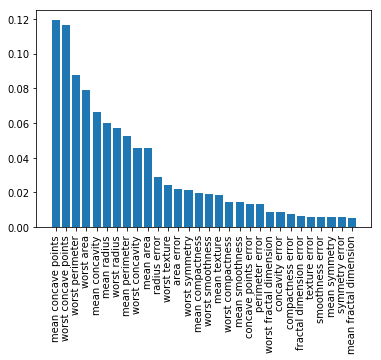

In [95]:
classifier = classifier.fit(cancer.data, cancer.target)
plot_feature_importances(classifier, cancer.feature_names)

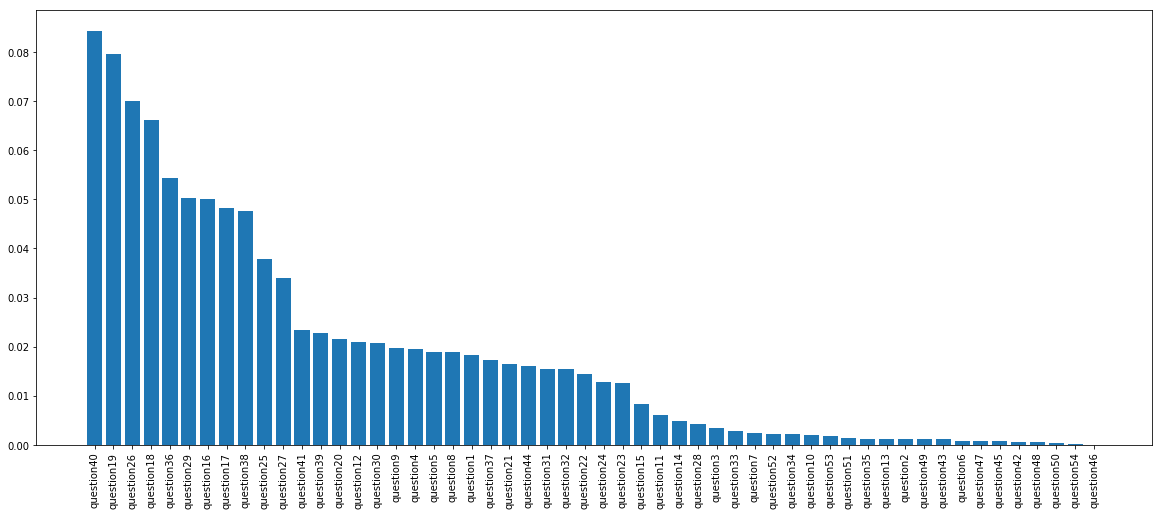

In [96]:
classifier = classifier.fit(divorces['data'], divorces['target'])

# treści pytań są długie, wykres etykietujemy więc samymi ich numerami
labels = np.array(['question' + str(i) for i in range(1, len(divorces['feature_names']) + 1)])
plot_feature_importances(classifier, labels, size=(20, 8))